In [1]:
# === Import and paths ===
import os
import re
import glob
from datetime import datetime

import numpy as np
import pandas as pd

# Folders
CONFIG_DIR = "plant_config"   # df_ILR_power.csv, meta.json, etc. are located here
RESULTS_DIR = "results"       # *_results.pkl per city are located here

In [2]:
# === Load plant configuration ===

def load_plant_config(config_dir="plant_config"):
    """
    Load:

    coord_df.csv
    
    df_ILR_power.csv
    
    inverter.json, module.json, temperature_parameters.json (if needed)
    
    meta.json → contains P_AC_output_power_inverter_MW
    """
    paths = {
        "coord_df": os.path.join(config_dir, "coord_df.csv"),
        "df_ILR_power": os.path.join(config_dir, "df_ILR_power.csv"),
        "inverter": os.path.join(config_dir, "inverter.json"),
        "module": os.path.join(config_dir, "module.json"),
        "temperature_parameters": os.path.join(config_dir, "temperature_parameters.json"),
        "meta": os.path.join(config_dir, "meta.json"),
    }
    for k, p in paths.items():
        if not os.path.exists(p):
            raise FileNotFoundError(f"Falta {k}: {p}")

    coord_df = pd.read_csv(paths["coord_df"]).set_index("city")
    df_ILR_power = pd.read_csv(paths["df_ILR_power"])

    # JSON files (not used directly for clipping, but returned in case they’re needed)
    import json
    with open(paths["inverter"], "r", encoding="utf-8") as f:
        inverter = json.load(f)
    with open(paths["module"], "r", encoding="utf-8") as f:
        module = json.load(f)
    with open(paths["temperature_parameters"], "r", encoding="utf-8") as f:
        temperature_parameters = json.load(f)
    with open(paths["meta"], "r", encoding="utf-8") as f:
        meta = json.load(f)

    pac_nominal_mw = float(meta["P_AC_output_power_inverter_MW"])  # MW AC nominal
    ilr_values = df_ILR_power["ILR"].astype(float).tolist()

    return {
        "coord_df": coord_df,
        "df_ILR_power": df_ILR_power,
        "inverter": inverter,
        "module": module,
        "temperature_parameters": temperature_parameters,
        "meta": meta,
        "pac_nominal_mw": pac_nominal_mw,
        "ilr_values": ilr_values,
    }

# Load config
cfg = load_plant_config(CONFIG_DIR)
PAC_MW = cfg["pac_nominal_mw"]
DF_ILR_POWER = cfg["df_ILR_power"]  # ILR -> P_DC_input_power_inverter_MWp
print("✔ PAC nominal [MW]:", PAC_MW, "| ILR count:", len(cfg["ilr_values"]))

✔ PAC nominal [MW]: 50.05 | ILR count: 40


In [3]:
# === Helpers ===

def load_city_results(city: str, results_dir: str = RESULTS_DIR) -> pd.DataFrame:
    """
    Read results/{City}_results.pkl and return a DataFrame with a UTC index
    """
    path = os.path.join(results_dir, f"{city.replace(' ', '_')}_results.pkl")
    if not os.path.exists(path):
        raise FileNotFoundError(f"No existe: {path}")
    df = pd.read_pickle(path)
    if df.index.tz is None:
        df.index = df.index.tz_localize("UTC")
    else:
        df.index = df.index.tz_convert("UTC")
    return df

def find_ilr_columns(df: pd.DataFrame):
    """
    Return a list of tuples (ilr, col_ac, col_dc) only if both columns exist for that ILR.
    """
    ac_map, dc_map = {}, {}
    for c in df.columns:
        m_ac = re.fullmatch(r"AC_MW_ILR_([0-9.]+)", c)
        m_dc = re.fullmatch(r"DC_MW_ILR_([0-9.]+)", c)
        if m_ac:
            ac_map[float(m_ac.group(1))] = c
        if m_dc:
            dc_map[float(m_dc.group(1))] = c
    ilrs = sorted(set(ac_map).intersection(dc_map))
    return [(ilr, ac_map[ilr], dc_map[ilr]) for ilr in ilrs]

def pdc_from_ilr(ilr: float, df_ilr_power: pd.DataFrame) -> float:
    """
    DC field power (MWp) for a given ILR, using the saved df_ILR_power.csv.
Find the closest ILR in case of slight rounding differences.
    """
    j = (df_ilr_power["ILR"] - ilr).abs().idxmin()
    return float(df_ilr_power.loc[j, "P_DC_input_power_inverter_MWp"])

In [4]:
# === Celda 4: Cálculo de clipping ===

def compute_city_clipping(
    city: str,
    df_ilr_power: pd.DataFrame,
    pac_nominal_mw: float,
    inverter_eff: float = 0.985,
    results_dir: str = RESULTS_DIR,
) -> pd.DataFrame:
    """
    Compute annual clipping for 'city' using its PKL file and return a DataFrame aggregated by ILR.

    Output columns:
    
    City
    
    ILR
    
    DC_SolarField_Power_MW
    
    AC_energy_MWh
    
    DC_energy_MWh
    
    AC_energy_MWh_ILR_1_0
    
    clipping_energy_MWh (negative)
    
    energy_increase_percentage
    
    energy_loss_to_inverter
    """
    df = load_city_results(city, results_dir)
    ilr_cols = find_ilr_columns(df)
    if not ilr_cols:
        raise ValueError(f"No se detectaron columnas AC/DC por ILR en results/{city}_results.pkl")

    # Reference ILR ≈ 1.0 (if not exact, uses the closest one)
    ilr_ref = min([ilr for ilr, _, _ in ilr_cols], key=lambda x: abs(x - 1.0))
    ac_ref_col = next(ac for (ilr, ac, _) in ilr_cols if ilr == ilr_ref)
    ac_ref_mwh = df[ac_ref_col].sum() / 60.0  # MW-min -> MWh

    rows = []
    for ilr, ac_col, dc_col in ilr_cols:
        ac = df[ac_col]
        dc = df[dc_col]

        # Clipping power when AC ≥ inverter nominal.
        clip_power = np.where(
            ac.values >= pac_nominal_mw,
            (dc.values * inverter_eff) - pac_nominal_mw,
            0.0
        )
        clip_power = np.maximum(clip_power, 0.0)  # avoid negatives in rounding

        rows.append({
            "City": city,
            "ILR": float(ilr),
            "DC_SolarField_Power_MW": pdc_from_ilr(ilr, df_ilr_power),
            "AC_energy_MWh": float(ac.sum() / 60.0),
            "DC_energy_MWh": float(dc.sum() / 60.0),
            "AC_energy_MWh_ILR_1_0": float(ac_ref_mwh),
            # clipping in negative
            "clipping_energy_MWh": float(-(clip_power.sum() / 60.0)),
        })

    out = pd.DataFrame(rows).sort_values(["City","ILR"]).reset_index(drop=True)
    out["energy_increase_percentage"] = (
        (out["AC_energy_MWh"] - out["AC_energy_MWh_ILR_1_0"]) / out["AC_energy_MWh_ILR_1_0"] * 100.0
    )
    out["energy_loss_to_inverter"] = (
        out["clipping_energy_MWh"] / (out["AC_energy_MWh"] + out["clipping_energy_MWh"]) * 100.0
    )
    return out


def compute_all_cities_clipping(
    df_ilr_power: pd.DataFrame,
    pac_nominal_mw: float,
    results_dir: str = RESULTS_DIR,
    inverter_eff: float = 0.985,
    export_csv: str | None = "auto",
) -> pd.DataFrame:
    """
    Compute clipping for all *_results.pkl files in results_dir.

    export_csv:
    
    "auto" → create clippingdf_group_results_YYYY_MM_DD_HH_MM_SS.csv
    
    str (path) → save with that name
    
    None → do not export
    """
    pkl_files = sorted(glob.glob(os.path.join(results_dir, "*_results.pkl")))
    if not pkl_files:
        raise FileNotFoundError(f"No se encontraron PKL en {results_dir}")

    all_out = []
    for p in pkl_files:
        city = os.path.basename(p).replace("_results.pkl", "").replace("_", " ")
        try:
            out_city = compute_city_clipping(
                city,
                df_ilr_power=df_ilr_power,
                pac_nominal_mw=pac_nominal_mw,
                inverter_eff=inverter_eff,
                results_dir=results_dir,
            )
            all_out.append(out_city)
            print(f"✔ Clipping: {city}")
        except Exception as e:
            print(f"❌ {city} -> {e}")

    clippingdf_group = pd.concat(all_out, ignore_index=True)

    if export_csv is not None:
        if export_csv == "auto":
            ts = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
            export_csv = f"clippingdf_group_results_{ts}.csv"
        clippingdf_group.to_csv(export_csv, index=False)
        print(f"💾 Exportado: {export_csv}")

    return clippingdf_group

In [5]:
# === Running examples ===

# 1) City clipping (i.e, Madrid)
# clp_mad = compute_city_clipping("Madrid", df_ilr_power=DF_ILR_POWER, pac_nominal_mw=PAC_MW)
# clp_mad.head()

# 2) Simulated cities clipping (Reads all *_results.pkl)
#     Export CSV with timestamp.
# clippingdf_group = compute_all_cities_clipping(
#     df_ilr_power=DF_ILR_POWER,
#     pac_nominal_mw=PAC_MW,
#     results_dir=RESULTS_DIR,
#     inverter_eff=0.985,
#     export_csv="auto",  # o None for not exporting
# )
# clippingdf_group.head()

In [6]:
# === Annual AC energy at ILR≈1.0 by city ===

def ac_energy_ilr1_by_city(clippingdf_group: pd.DataFrame) -> pd.DataFrame:
    """
    Select, for each city, the row whose ILR is closest to 1.0.
    """
    tmp = (clippingdf_group
           .assign(_d=(clippingdf_group["ILR"]-1.0).abs())
           .sort_values(["City","_d"])
           .drop(columns="_d"))
    out = tmp.groupby("City", as_index=False).first()[["City","AC_energy_MWh_ILR_1_0"]]
    out = out.rename(columns={"City":"City", "AC_energy_MWh_ILR_1_0":"Annual_AC_Energy_ILR_1.0_MWh"})
    return out

# Example:
# ac1 = ac_energy_ilr1_by_city(clippingdf_group)
# ac1.head()

In [7]:
# === Full table: ALL cities x ALL ILRs, with ILR_ref and PDC ===
    # - AC/DC energy per ILR:
    #   - AC_energy_MWh
    #   - DC_energy_MWh
    
    # - Clipping per ILR:
    #   - clipping_energy_MWh (negative, as in your pipeline)
    
    # - Increase vs ILR≈1.0:
    #   - energy_increase_percentage
    #   - AC_energy_delta_MWh
    
    # - % loss due to clipping:
    #   - energy_loss_to_inverter
    
    # - Per-city reference ILR:
    #   - ILR_ref_for_city
    
    # - Field PDC for that ILR:
    #   - PDC_MWp
    
    # - Plant nominal PAC:
    #   - PAC_MW
    
    # - Reference energy at ILR≈1.0:
    #   - AC_energy_MWh_ILR_1_0

from datetime import datetime

# 1) Load config if not in memory
try:
    PAC_MW, DF_ILR_POWER
except NameError:
    cfg = load_plant_config(CONFIG_DIR)
    PAC_MW = cfg["pac_nominal_mw"]
    DF_ILR_POWER = cfg["df_ILR_power"]

# 2) Compute clipping for all cities if it doesn’t already exist.
try:
    clippingdf_group
except NameError:
    clippingdf_group = compute_all_cities_clipping(
        df_ilr_power=DF_ILR_POWER,
        pac_nominal_mw=PAC_MW,
        results_dir=RESULTS_DIR,
        inverter_eff=0.985,
        export_csv=None,   # Not exporting here; We export data at the end of the process
    )

# 3) Add reference ILR ≈1.0 per ciudad
ref_map = (
    clippingdf_group
    .assign(_d=(clippingdf_group["ILR"] - 1.0).abs())
    .sort_values(["City", "_d"])
    .groupby("City", as_index=True)["ILR"]
    .first()
)
full_table = clippingdf_group.copy()
full_table["ILR_ref_for_city"] = full_table["City"].map(ref_map)

# 4) Add PAC
#    (compute_city_clipping already brings PDC from df_ILR_power; we just rename it)
full_table = full_table.rename(columns={"DC_SolarField_Power_MW": "PDC_MWp"})
full_table["PAC_MW"] = PAC_MW

# 5) Delta energy AC vs ILR≈1.0 (in MWh)
full_table["AC_energy_delta_MWh"] = full_table["AC_energy_MWh"] - full_table["AC_energy_MWh_ILR_1_0"]

# 6) Order columns
cols_order = [
    "City", "ILR", "ILR_ref_for_city",
    "PAC_MW", "PDC_MWp",
    "AC_energy_MWh", "AC_energy_MWh_ILR_1_0", "AC_energy_delta_MWh",
    "DC_energy_MWh",
    "clipping_energy_MWh",
    "energy_increase_percentage", "energy_loss_to_inverter",
]
# Keep extra columns
cols_order += [c for c in full_table.columns if c not in cols_order]
full_table = full_table[cols_order].sort_values(["City","ILR"]).reset_index(drop=True)

# 7) Export to csv with timestamp
ts = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
out_csv = f"all_cities_all_ILR_energy_{ts}.csv"
full_table.to_csv(out_csv, index=False)
print(f"💾 Exportado: {out_csv}")

# Quick look
full_table.head()

✔ Clipping: Amsterdam
✔ Clipping: Athens
✔ Clipping: Berlin
✔ Clipping: Bratislava
✔ Clipping: Brussels
✔ Clipping: Bucharest
✔ Clipping: Budapest
✔ Clipping: Copenhagen
✔ Clipping: Dublin
✔ Clipping: Helsinki
✔ Clipping: Lisbon
✔ Clipping: Ljubljana
✔ Clipping: London
✔ Clipping: Luxembourg
✔ Clipping: Madrid
✔ Clipping: Nicosia
✔ Clipping: Paris
✔ Clipping: Prague
✔ Clipping: Riga
✔ Clipping: Rome
✔ Clipping: Sofia
✔ Clipping: Stockholm
✔ Clipping: Tallinn
✔ Clipping: Valletta
✔ Clipping: Vienna
✔ Clipping: Vilnius
✔ Clipping: Warsaw
✔ Clipping: Zagreb
💾 Exportado: all_cities_all_ILR_energy_2025_10_07_13_10_49.csv


,City,ILR,ILR_ref_for_city,PAC_MW,PDC_MWp,AC_energy_MWh,AC_energy_MWh_ILR_1_0,AC_energy_delta_MWh,DC_energy_MWh,clipping_energy_MWh,energy_increase_percentage,energy_loss_to_inverter
0,Amsterdam,1.00,1.0,50.05,50.09,43289.709469,43289.709469,0.000000,44143.717124,-0.000000,0.000000,-0.000000
1,Amsterdam,1.05,1.0,50.05,52.46,45340.811361,43289.709469,2051.101892,46225.967931,-0.000000,4.738082,-0.000000
2,Amsterdam,1.10,1.0,50.05,54.82,47391.195372,43289.709469,4101.485903,48308.218739,-0.000000,9.474505,-0.000000
3,Amsterdam,1.14,1.0,50.05,57.18,49440.860070,43289.709469,6151.150600,50390.469547,-0.000000,14.209267,-0.000000
4,Amsterdam,1.19,1.0,50.05,59.54,51487.159193,43289.709469,8197.449724,52472.720354,-3.312611,18.936255,-0.006434


In [8]:
#Comparativa de ciudades
import numpy as np
import pandas as pd

def rewrite_reference_columns(clippingdf_group: pd.DataFrame, baseline: str = "first") -> pd.DataFrame:
    """
    Rewrite reference 'ILR 1.0' per ciudad and calculate metrics.
    
    Parameters

    clippingdf_group : DataFrame
    Table grouped by city/ILR with at least:
    ['City', 'ILR', 'AC_energy_MWh', (optional 'PAC_MW'), 'clipping_energy_MWh', 'energy_loss_to_inverter', (optional 'DC_SolarField_Power_MW' or 'PDC_MWp')]
    
    baseline : {'first', 'nearest1.0', 'exact1.0'}
    
    'first' → uses the minimum ILR per city (equivalent to your old ac_outputs[0]).
    
    'nearest1.0' → uses the ILR available for that city that is closest to 1.0.
    
    'exact1.0' → requires ILR == 1.0 exactly for that city (if missing, it raises an error).
    
    Returns
    
    DataFrame with updated/added columns:
    
    ILR_ref_for_city
    
    AC_energy_MWh_ILR_1_0 (recomputed according to the chosen reference)
    
    AC_energy_delta_MWh
    
    energy_increase_percentage
    """
    req = {"City", "ILR", "AC_energy_MWh"}
    missing = req - set(clippingdf_group.columns)
    if missing:
        raise ValueError(f"Faltan columnas requeridas: {sorted(missing)}")

    df = clippingdf_group.copy()

    # 1) Choose reference ILR per city
    def pick_ref_ilr(sub: pd.DataFrame) -> float:
        ilrs = sub["ILR"].to_numpy(dtype=float)
        if baseline == "first":
            return float(np.min(ilrs))
        elif baseline == "nearest1.0":
            return float(ilrs[np.argmin(np.abs(ilrs - 1.0))])
        elif baseline == "exact1.0":
            if np.any(np.isclose(ilrs, 1.0, atol=1e-9)):
                return 1.0
            raise ValueError(f"No existe ILR=1.0 exacto para {sub['City'].iloc[0]}")
        else:
            raise ValueError("baseline debe ser 'first', 'nearest1.0' o 'exact1.0'.")

    ref_map = (
        df.groupby("City", as_index=True)
          .apply(pick_ref_ilr)
    )
    df["ILR_ref_for_city"] = df["City"].map(ref_map)

    # 2)  AC de reference energy production per city (selected ILR_ref)
    #    (select the row whose ILR is closest to ILR_ref)
    ref_energy_map = (
        df.assign(_d=(df["ILR"] - df["ILR_ref_for_city"]).abs())
          .sort_values(["City", "_d"])
          .groupby("City", as_index=True)["AC_energy_MWh"]
          .first()
    )
    df["AC_energy_MWh_ILR_1_0"] = df["City"].map(ref_energy_map)

    # 3) Delta and increment percentage vs reference
    df["AC_energy_delta_MWh"] = df["AC_energy_MWh"] - df["AC_energy_MWh_ILR_1_0"]

    denom = df["AC_energy_MWh_ILR_1_0"].replace({0.0: np.nan})
    df["energy_increase_percentage"] = (df["AC_energy_delta_MWh"] / denom) * 100.0


    preferred = [
        "City", "ILR", "ILR_ref_for_city",
        "PAC_MW", "DC_SolarField_Power_MW", "PDC_MWp",
        "AC_energy_MWh", "AC_energy_MWh_ILR_1_0", "AC_energy_delta_MWh",
        "DC_energy_MWh", "clipping_energy_MWh",
        "energy_increase_percentage", "energy_loss_to_inverter",
    ]
    ordered = [c for c in preferred if c in df.columns]
    rest = [c for c in df.columns if c not in ordered]
    return df[ordered + rest].sort_values(["City", "ILR"]).reset_index(drop=True)
city = "Paris"


new_tbl = compute_city_clipping(city, df_ilr_power=DF_ILR_POWER, pac_nominal_mw=PAC_MW)
new_tbl = rewrite_reference_columns(new_tbl, baseline='first')


df = load_city_results(city)
ilr_cols = sorted([float(c.split("_")[-1]) for c in df.columns if c.startswith("AC_MW_ILR_")])
ilr_first = ilr_cols[0]
ac_ref_mwh_old = df[f"AC_MW_ILR_{ilr_first}"].sum()/60.0

rows_old = []
for ilr in ilr_cols:
    ac = df[f"AC_MW_ILR_{ilr}"]; dc = df[f"DC_MW_ILR_{ilr}"]
    clip_p = np.where(ac.values >= PAC_MW, (dc.values*0.985) - PAC_MW, 0.0)  # SIN clamp
    rows_old.append({
        "ILR": ilr,
        "AC_energy_MWh": ac.sum()/60.0,
        "DC_energy_MWh": dc.sum()/60.0,
        "clipping_energy_MWh": -(clip_p.sum()/60.0),
        "AC_energy_MWh_ILR_1_0": ac_ref_mwh_old
    })
old_tbl = pd.DataFrame(rows_old).sort_values("ILR").reset_index(drop=True)
old_tbl["energy_increase_percentage"] = (
    (old_tbl["AC_energy_MWh"] - old_tbl["AC_energy_MWh_ILR_1_0"]) / old_tbl["AC_energy_MWh_ILR_1_0"] * 100
)
old_tbl["energy_loss_to_inverter"] = (
    old_tbl["clipping_energy_MWh"] / (old_tbl["AC_energy_MWh"] + old_tbl["clipping_energy_MWh"]) * 100
)

# 3) Comparison
cmp = new_tbl.merge(old_tbl, on="ILR", suffixes=("_new","_old"))
for col in ["AC_energy_MWh","DC_energy_MWh","clipping_energy_MWh",
            "AC_energy_MWh_ILR_1_0","energy_increase_percentage","energy_loss_to_inverter"]:
    diff = (cmp[f"{col}_new"] - cmp[f"{col}_old"]).abs().max()
    print(f"{col}: max |diff| = {diff:.6f}")

C:\Users\danie\AppData\Local\Temp\ipykernel_6408\3563034920.py:53: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pick_ref_ilr)


AC_energy_MWh: max |diff| = 0.000000
DC_energy_MWh: max |diff| = 0.000000
clipping_energy_MWh: max |diff| = 0.000000
AC_energy_MWh_ILR_1_0: max |diff| = 0.000000
energy_increase_percentage: max |diff| = 0.000000
energy_loss_to_inverter: max |diff| = 0.000000


In [9]:
full_table

,City,ILR,ILR_ref_for_city,PAC_MW,PDC_MWp,AC_energy_MWh,AC_energy_MWh_ILR_1_0,AC_energy_delta_MWh,DC_energy_MWh,clipping_energy_MWh,energy_increase_percentage,energy_loss_to_inverter
0,Amsterdam,1.00,1.0,50.05,50.09,43289.709469,43289.709469,0.000000,44143.717124,-0.000000,0.000000,-0.000000
1,Amsterdam,1.05,1.0,50.05,52.46,45340.811361,43289.709469,2051.101892,46225.967931,-0.000000,4.738082,-0.000000
2,Amsterdam,1.10,1.0,50.05,54.82,47391.195372,43289.709469,4101.485903,48308.218739,-0.000000,9.474505,-0.000000
3,Amsterdam,1.14,1.0,50.05,57.18,49440.860070,43289.709469,6151.150600,50390.469547,-0.000000,14.209267,-0.000000
4,Amsterdam,1.19,1.0,50.05,59.54,51487.159193,43289.709469,8197.449724,52472.720354,-3.312611,18.936255,-0.006434
...,...,...,...,...,...,...,...,...,...,...,...,...
1115,Zagreb,2.65,1.0,50.05,132.79,117507.450061,56300.964512,61206.485549,152033.300601,-32108.520151,108.713032,-37.598270
1116,Zagreb,2.70,1.0,50.05,135.16,118500.648653,56300.964512,62199.684141,154738.519473,-33780.978896,110.477120,-39.873832
1117,Zagreb,2.75,1.0,50.05,137.52,119472.915157,56300.964512,63171.950645,157443.738345,-35474.309756,112.204029,-42.232022
1118,Zagreb,2.79,1.0,50.05,139.88,120424.036009,56300.964512,64123.071497,160148.957217,-37189.004463,113.893380,-44.679510


In [10]:
## === Gráfico verde/rojo por ciudad desde all_cities_all_ILR_energy.csv ===


## Plot a green/red chart by city from all_cities_all_ILR_energy.csv.

## Green bars: % Energy increase vs ILR≈1.0

## Red bars: % Energy clipping

## Each subplot corresponds to one city.

## Data are read from the file all_cities_all_ILR_energy.cs


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FULL_TABLE = "all_cities_all_ILR_energy.csv"

def plot_city_ilr_greenred(city: str,
                           path: str = FULL_TABLE,
                           save: str | None = None,
                           symmetric_ylim: bool = False,
                           pad: float = 5.0,
                           bar_width: float = 0.3):  # ← Narrow):
    """
    Plot % Energy increase vs ILR≈1.0 (green) and % Energy clipping (red) for each ILR.

    symmetric_ylim=True forces symmetric axes around 0.

    pad expands the top/bottom margin in percentage points.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"No existe {path}")

    df = pd.read_csv(path)
    need = ["City","ILR","energy_increase_percentage","energy_loss_to_inverter"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError(f"Faltan columnas en {path}: {missing}")

    sub = df[df["City"].str.casefold() == city.casefold()].copy()
    if sub.empty:
        raise ValueError(f"No hay datos para '{city}' en {path}")

    sub = sub.sort_values("ILR")
    x = np.arange(len(sub))
    labels = [f"{v:g}" for v in sub["ILR"]]
    y_inc  = sub["energy_increase_percentage"].to_numpy()     # positivo
    y_clip = sub["energy_loss_to_inverter"].to_numpy()        # ya negativo

    fig, ax = plt.subplots(figsize=(14, 8))

    # Centered bars in same axis
    ax.bar(x, y_inc,  width=bar_width, color="green", label="% Energy increase over ILR 1.0")
    ax.bar(x, y_clip, width=bar_width, color="red",   label="% Energy Clipping (annual)")

    # Aesthetics
    ax.axhline(0, color="black", linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.set_xlabel("Inverter Loading Ratio (ILR)", fontsize=12)
    ax.set_ylabel("%", fontsize=12)
    ax.set_title(f"Clipping & Energy Gain vs ILR – {sub['City'].iloc[0]}", fontsize=14)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.legend(fontsize=11)

    # Límites del eje Y
    ymin = min(y_clip.min(), 0.0)
    ymax = max(y_inc.max(), 0.0)
    if symmetric_ylim:
        m = max(abs(ymin), abs(ymax))
        ax.set_ylim(-m - pad, m + pad)
    else:
        ax.set_ylim(ymin - pad, ymax + pad)

    plt.tight_layout()
    if save:
        plt.savefig(save, dpi=150, bbox_inches="tight")
    plt.show()

# Examples:
# plot_city_ilr_greenred("Madrid")                       
# plot_city_ilr_greenred("Madrid", symmetric_ylim=True)  
# plot_city_ilr_greenred("Madrid", save="madrid_ilr.png")

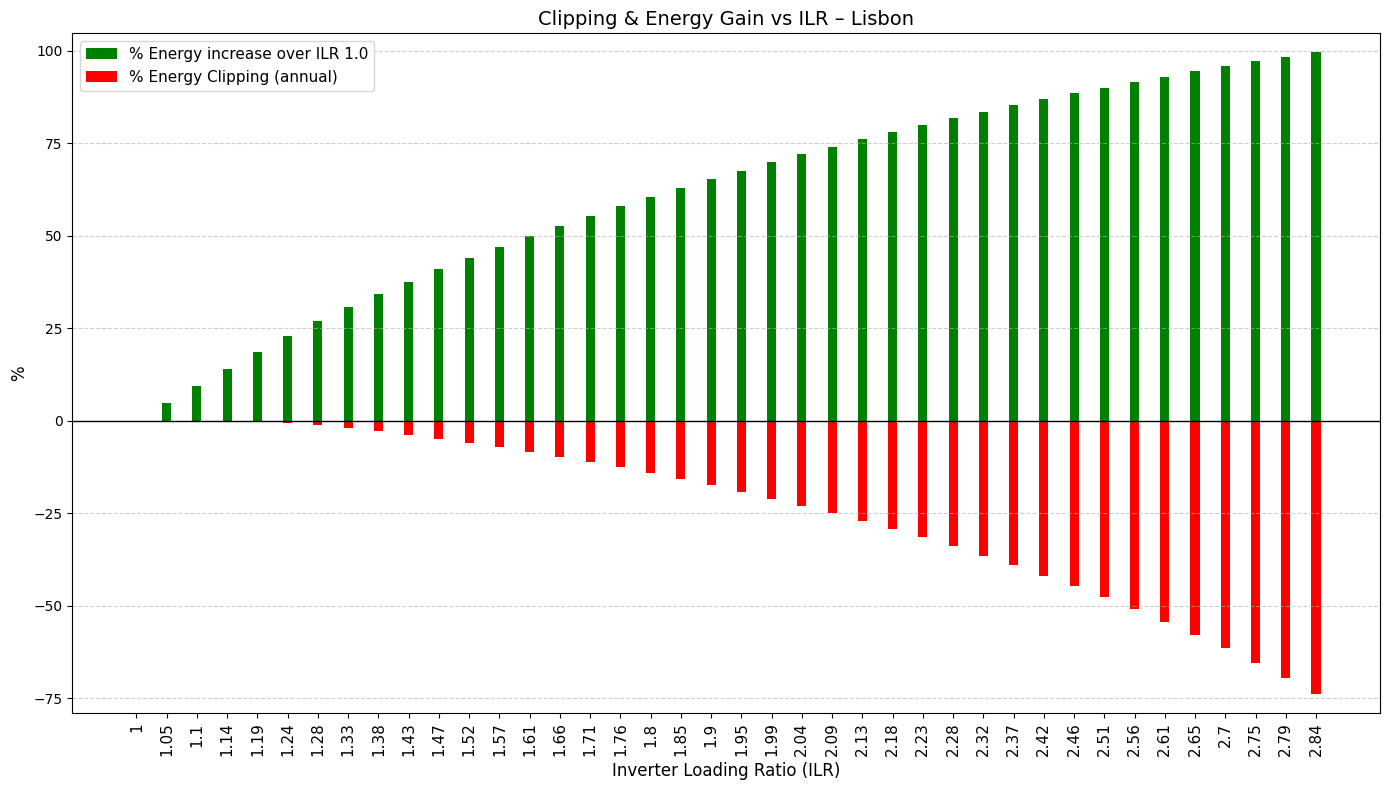

In [11]:
plot_city_ilr_greenred("Lisbon")

In [12]:
# === Grid de ciudades: barras verde/rojo desde all_cities_all_ILR_energy.csv ===
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FULL_TABLE = "all_cities_all_ILR_energy.csv"

def plot_cities_grid_ilr(cities,
                         path: str = FULL_TABLE,
                         ncols: int = 2,
                         sharey: bool = True,
                         symmetric_ylim: bool = False,
                         pad: float = 5.0,
                         bar_width: float = 0.3,
                         xtick_step: int = 2,
                         suptitle: str | None = None,
                         figsize_per_ax=(7, 4)):
    """
    Plot % Energy increase (green) and % Energy clipping (red) vs. ILR in a grid.

    cities: list of cities (case-insensitive)
    
    ncols: number of columns in the grid
    
    sharey: if True, use the same Y axis for all plots (useful for comparison)
    
    symmetric_ylim: if True, make the Y axis symmetric ±max with extra pad
    
    pad: extra margin on the Y axis (percentage points)
    
    bar_width: bar width
    
    xtick_step: show 1 out of every xtick_step ILR labels for readability
    
    figsize_per_ax: size per subplot (width, height) in inches
    """

    if not os.path.exists(path):
        raise FileNotFoundError(f"No existe {path}")

    df = pd.read_csv(path)
    need = ["City","ILR","energy_increase_percentage","energy_loss_to_inverter"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError(f"Faltan columnas en {path}: {missing}")

    # normalize
    df["ILR"] = pd.to_numeric(df["ILR"], errors="coerce")
    df = df.dropna(subset=["ILR"]).sort_values(["City","ILR"]).reset_index(drop=True)

    # prepare grid
    n = len(cities)
    ncols = max(1, int(ncols))
    nrows = math.ceil(n / ncols)
    fig_w = figsize_per_ax[0] * ncols
    fig_h = figsize_per_ax[1] * nrows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_w, fig_h), squeeze=False)

    # global limits
    global_min, global_max = 0.0, 0.0
    per_city_data = []

    for city in cities:
        sub = df[df["City"].str.casefold() == str(city).casefold()].copy()
        if sub.empty:
            per_city_data.append((city, None))
            continue
        y_inc  = sub["energy_increase_percentage"].to_numpy()
        y_clip = sub["energy_loss_to_inverter"].to_numpy()
        ymin = min(y_clip.min(), 0.0)
        ymax = max(y_inc.max(), 0.0)
        global_min = min(global_min, ymin)
        global_max = max(global_max, ymax)
        per_city_data.append((city, sub))

    for i, (city, sub) in enumerate(per_city_data):
        r, c = divmod(i, ncols)
        ax = axes[r, c]

        if sub is None:
            ax.set_axis_off()
            ax.text(0.5, 0.5, f"Sin datos:\n{city}", ha="center", va="center", fontsize=12)
            continue

        x = np.arange(len(sub))
        labels = [f"{v:g}" for v in sub["ILR"]]
        y_inc  = sub["energy_increase_percentage"].to_numpy()
        y_clip = sub["energy_loss_to_inverter"].to_numpy()

        ax.bar(x, y_inc,  width=bar_width, color="green", label="% Energy increase over ILR 1.0")
        ax.bar(x, y_clip, width=bar_width, color="red",   label="% Energy Clipping (annual)")

        ax.axhline(0, color="black", linewidth=1)
        ax.set_title(f"{city}: Clipping & Energy Gain vs ILR", fontsize=12)
        ax.set_ylabel("%", fontsize=11)

        # xticks
        show_idx = np.arange(len(labels))[::max(1, int(xtick_step))]
        ax.set_xticks(show_idx)
        ax.set_xticklabels([labels[j] for j in show_idx], rotation=90, fontsize=9)

        # Y-axis limits
        if sharey:
            if symmetric_ylim:
                m = max(abs(global_min), abs(global_max))
                ax.set_ylim(-m - pad, m + pad)
            else:
                ax.set_ylim(global_min - pad, global_max + pad)
        else:
            ymin = min(y_clip.min(), 0.0); ymax = max(y_inc.max(), 0.0)
            if symmetric_ylim:
                m = max(abs(ymin), abs(ymax))
                ax.set_ylim(-m - pad, m + pad)
            else:
                ax.set_ylim(ymin - pad, ymax + pad)

        ax.grid(axis="y", linestyle="--", alpha=0.6)

        # Legend (upper left)
        if i == 0:
            ax.legend(fontsize=10, loc="upper left")

    # hide additional axes
    for j in range(n, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].set_axis_off()

    if suptitle:
        fig.suptitle(suptitle, fontsize=14, y=0.98)

    # common x-axis label
    fig.text(0.5, 0.03, "Inverter Loading Ratio (ILR)", ha="center", fontsize=12)
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

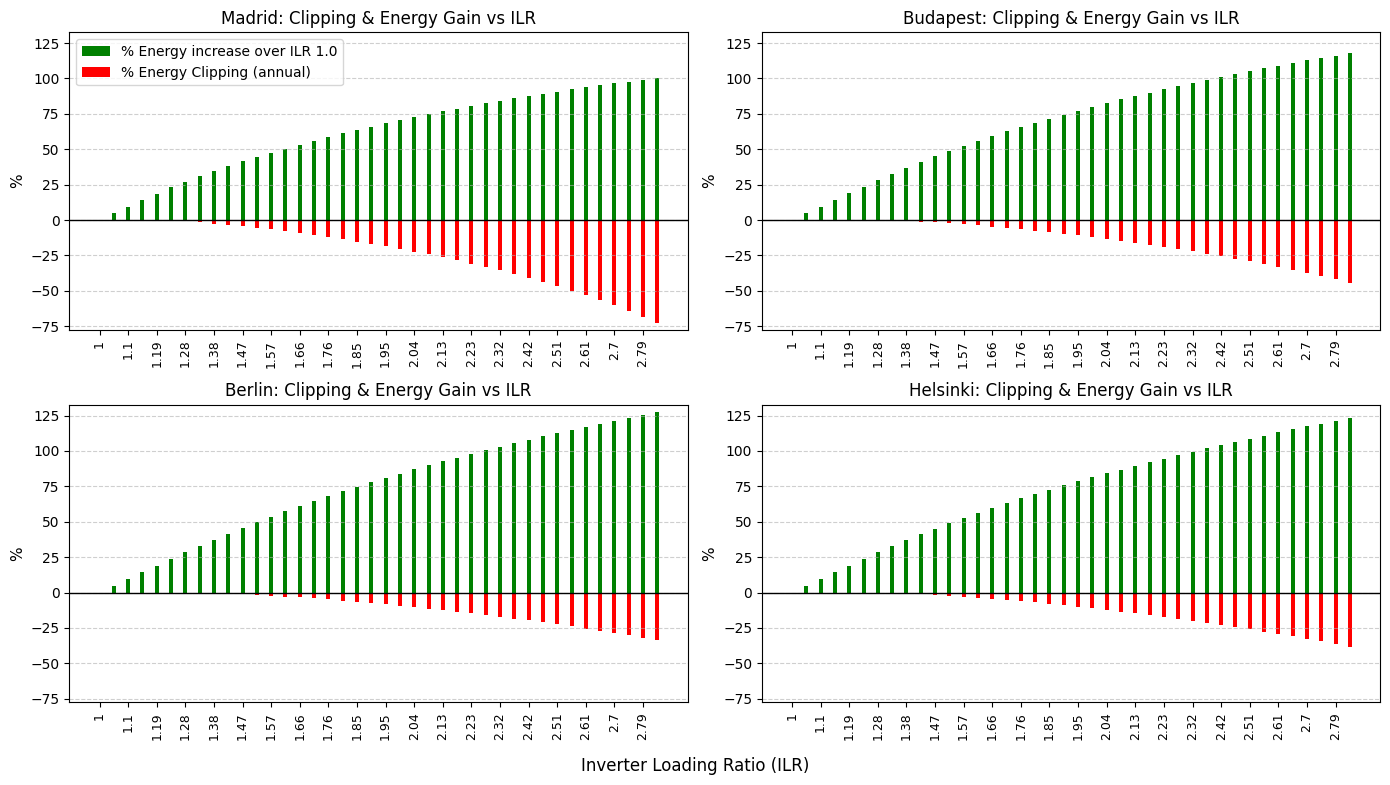

In [13]:
plot_cities_grid_ilr(
    ["Madrid","Budapest","Berlin","Helsinki"],
    ncols=2,
    sharey=True,
    symmetric_ylim=False,
    bar_width=0.28,
    xtick_step=2,
    #suptitle="Clipping & Energy Gain vs ILR — 4 ciudades"
)